In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np
import itertools
import random
import spacy

from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from pandarallel import pandarallel
pandarallel.initialize()

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus
from src.data_disambiguation import DisDataset, read_disambiguation_corpus
from src.model import BertForSharedTaskBaseline
from src.training import train, evaluate, forward_func_custom_bert

Using TensorFlow backend.


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput, TokenClassifierOutput

_CONFIG_FOR_DOC = "BertConfig"
_TOKENIZER_FOR_DOC = "BertTokenizer"

class BertTaggingForSharedTaskMultitask(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.vocab_tag = 8
        self.embed_dim = 7
        
        self.num_labels_first_task = 1 # Regression
        self.num_labels_second_task = config.num_labels # Word sense disambiguation

        self.bert = BertModel(config)
        self.dropout_first = nn.Dropout(config.hidden_dropout_prob)
        self.dropout_second = nn.Dropout(config.hidden_dropout_prob)
        self.embed_first = nn.Embedding(self.vocab_tag, self.embed_dim)
        
        self.classifier_first = nn.Linear(config.hidden_size + self.embed_dim, self.num_labels_first_task)
        self.classifier_second = nn.Linear(config.hidden_size, self.num_labels_second_task)

        self.init_weights()
        

    def forward(
        self,
        input_ids=None,
        target_positions=None,
        task_id=1,
        attention_mask=None,
        token_type_ids=None,
        pos_tags=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if task_id == 1:
            #pooled_output = outputs[0][torch.arange(outputs[0].size(0)), target_positions]
            pooled_output = outputs[1]
            pooled_output = self.dropout_first(pooled_output)
            pos_tag_embeds = self.embed_first(pos_tags)
            #print(pos_tag_embeds.shape, pooled_output.shape)
            cat_output = torch.cat((pooled_output, pos_tag_embeds.squeeze(1)), dim=1)
            #print(pooled_output.shape)
            logits = self.classifier_first(cat_output)

            loss = None
            if labels is not None:
                if self.num_labels_first_task == 1:
                    #  We are doing regression
                    loss_fct = MSELoss()
                    loss = loss_fct(logits.view(-1).float(), labels.view(-1).float())
                else:
                    loss_fct = CrossEntropyLoss()
                    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output
            print(return_dict)
            print(loss)
            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
        elif task_id == 2:
            sequence_output = outputs[0]

            sequence_output = self.dropout_second(sequence_output)
            logits = self.classifier_second(sequence_output)

            loss = None
            if labels is not None:
                loss_fct = CrossEntropyLoss()
                # Only keep active parts of the loss
                if attention_mask is not None:
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = logits.view(-1, self.num_labels_second_task)
                    active_labels = torch.where(
                        active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                    )
                    loss = loss_fct(active_logits, active_labels)
                else:
                    loss = loss_fct(logits.view(-1, self.num_labels_second_task), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return TokenClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )


In [3]:
def forward_func_multitask_same_bert(batch, device, model, additional_params):

    # Clear gradients
    model.zero_grad()    
    
    
    b_input_ids = batch['task_1']['input_ids'].to(device)
    b_input_mask = batch['task_1']['attention_mask'].to(device)
    b_labels = batch['task_1']['labels'].to(device)
    b_pos_tags = batch['task_1']['pos_tag'].to(device)
    b_positions =  batch['task_1']['target_positions'].to(device)
      
    loss_1, logits = model(b_input_ids, 
                             b_positions,
                             task_id=1,
                             token_type_ids=None, 
                             pos_tags=b_pos_tags,
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    
    b_input_ids = batch['task_2']['input_ids'].to(device)
    b_input_mask = batch['task_2']['attention_mask'].to(device)
    b_labels = batch['task_2']['labels'].to(device)

    loss_2, _ = model(b_input_ids, 
                             task_id=2,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

    return 0.85 * loss_1 + 0.15 * loss_2, logits

In [4]:
def forward_func_multitask_bert(batch, device, model, additional_params):

    # Clear gradients
    model.zero_grad()      
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
        
    if additional_params['task_id'] == 1:
        b_labels = batch['labels'].to(device)
        b_pos_tags = batch['pos_tag'].to(device)
        b_positions =  batch['target_positions'].to(device)
      
        loss, logits = model(b_input_ids, 
                             b_positions,
                             task_id=1,
                             pos_tags=b_pos_tags,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    elif additional_params['task_id'] == 2:
        b_labels = batch['labels'].to(device)

        loss, logits = model(b_input_ids, 
                             task_id=2,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    return loss, logits

In [5]:
from xml.dom import minidom
from bs4 import BeautifulSoup
from pathlib import Path
import pandas as pd
import numpy as np
import torch

class ComposeMultiDataset(torch.utils.data.Dataset):
    def __init__(self, encodings_dis, labels_dis, encodings_lex, labels_lex, positions_lex, pos_tags_lex):
        self.encodings_dis = encodings_dis
        self.labels_dis = labels_dis
        
        self.encodings_lex = encodings_lex
        self.labels_lex = labels_lex
        self.pos_tags_lex = pos_tags_lex
        self.positions_lex = positions_lex

    def __getitem__(self, idx):
        item = {}
        
        task_1 = {key: torch.tensor(val[idx]) for key, val in self.encodings_lex.items()}
        task_1['labels'] = torch.tensor(self.labels_lex[idx])
        task_1['pos_tag'] = torch.tensor(self.pos_tags_lex[idx])
        task_1['target_positions'] = torch.tensor(self.positions_lex[idx])
        
        task_2 = {key: torch.tensor(val[idx]) for key, val in self.encodings_dis.items()}
        task_2['labels'] = torch.tensor(self.labels_dis[idx])
        
        item['task_2'] = task_2
        item['task_1'] = task_1
        return item

    def __len__(self):
        return len(self.labels_dis)
    
class ComposeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, positions, pos_tags):
        self.encodings = encodings
        self.labels = labels
        self.positions = positions
        self.pos_tags = pos_tags

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['pos_tag'] = torch.tensor(self.pos_tags[idx])
        item['target_positions'] = torch.tensor(self.positions[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [6]:
from pathlib import Path
import pandas as pd
import pandarallel
import numpy as np
import torch

import spacy

def get_meta(sentence, ref, nlp, option):
    try:
        temp = []
        doc = nlp(sentence)
        for token in doc:
            if option == 'pos':
                temp.append(token.pos_)
            else:
                temp.append(token.text)
        return temp        
    except:
        return []

# Cross-validation

In [7]:
epochs = 20
seed_val = 2
results_window = {}
max_len = 25
stop_at = 5
cuda_card = 1
nlp = spacy.load("en_core_web_sm")

In [8]:
data_sent_dis, data_senses_dis = read_disambiguation_corpus(max_len=max_len)

In [9]:
tag_values = list(set(list(itertools.chain(*data_senses_dis))))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [10]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0, 1, 2]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions, _, pos_tags = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                            nlp,
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    test_texts, _, test_labels, sentences_test, test_target_words, test_positions, _, test_pos_tags= read_lexical_corpus('data/raw/lcp_single_trial.xlsx',
                                                                            nlp,
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    le = LabelEncoder()
    le.fit(pos_tags)
    pos_tags_f = le.transform(pos_tags)
    test_pos_tags_f = le.transform(test_pos_tags)

    pos_tags_f = np.reshape(pos_tags_f, (-1, 1))
    test_pos_tags_f = np.reshape(test_pos_tags_f, (-1, 1))
    
    torch.cuda.manual_seed_all(seed_val)

    kf = StratifiedKFold(8, shuffle=True, random_state=0)

    history_preds_val = []
    history_preds_test = []
    history_samples_val = []
    history_samples_test = []
    history_input = []
    history_input_test = []
    history_target = []
    history_target_test = []
    history_index = []
    history_index_test = []
    history_labels_val = []
    history_labels_test = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    for train_index, val_index in kf.split(data_texts, data_corpus):
        print('Starting a new fold ...')
        
        train_index = list(train_index)
        random.seed(seed_val)
        random.shuffle(train_index)
        train_index = np.array(train_index)

        train_texts_lex, train_labels_lex, train_positions_lex, train_target_words_lex, train_pos_tags = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index], pos_tags_f[train_index]
        val_texts_lex, val_labels_lex, val_positions_lex, val_target_words_lex, val_pos_tags = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index], pos_tags_f[val_index]

        train_encodings_lex = tokenizer(list(train_texts_lex), truncation=True, padding=True)

        val_encodings_lex = tokenizer(list(val_texts_lex), truncation=True, padding=True)
        val_dataset_lex = ComposeDataset(val_encodings_lex, val_labels_lex, val_positions_lex, val_pos_tags)
        val_loader_lex = DataLoader(val_dataset_lex, batch_size=1)
        
        test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)
        test_dataset = ComposeDataset(test_encodings, test_labels, test_positions, test_pos_tags_f)
        test_loader = DataLoader(test_dataset, batch_size=1)
        
        all_text = ' '.join(train_texts_lex)
        occurence_text = [all_text.count(w) for w in val_target_words_lex]
        
        occurence_target = [train_target_words_lex.tolist().count(w) for w in val_target_words_lex]
        
        device = torch.device(f"cuda:{cuda_card}")
        #device = torch.device(f"cpu")
        
        model = BertTaggingForSharedTaskMultitask.from_pretrained(
            "bert-base-uncased", 
            num_labels = len(tag2idx), 
            output_attentions = False, 
            output_hidden_states = False, 
        )
        model.cuda(cuda_card)

        optimizer = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )

        random.seed(seed_val)
        torch.manual_seed(seed_val)

        tracking_metrics_val = []
        tracking_logits_val = []

        tracking_metrics_test = []
        tracking_logits_test = []
        
        early_stopping = 0
        best_metric = 1000000
        
        for epoch_i in range(0, epochs):
            np.random.seed(epoch_i)
            sample_data_sent = np.random.choice(data_sent_dis, len(train_texts_lex), replace=False)
            
            np.random.seed(epoch_i)
            sample_data_sense = np.random.choice(data_senses_dis, len(train_texts_lex), replace=False)
            
            train_encodings_dis = tokenizer(list(sample_data_sent), truncation=True, padding=True, max_length=max_len)
            data_tags_dis = pad_sequences([[tag2idx.get(l) for l in lab] for lab in sample_data_sense],
                     maxlen=max_len, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
            
            train_dataset_multi = ComposeMultiDataset(train_encodings_dis, data_tags_dis, train_encodings_lex, train_labels_lex, train_positions_lex, train_pos_tags)
            train_loader_multi = DataLoader(train_dataset_multi, batch_size=16)
            
            total_steps = len(train_loader_multi) * epochs
            scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)           
            print()
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            train(device, model, train_loader_multi, forward_func_multitask_same_bert, optimizer, scheduler, {})
            
            _, val_logits, val_metric = evaluate(device, model, val_loader_lex, forward_func_multitask_bert, {'task_id': 1})
            _, test_logits, test_metric = evaluate(device, model, test_loader, forward_func_multitask_bert, {'task_id': 1})

            tracking_metrics_val.append(val_metric)
            tracking_logits_val.append(val_logits)

            tracking_metrics_test.append(test_metric)
            tracking_logits_test.append(test_logits)
            
            if val_metric > best_metric:
                early_stopping += 1
            else:
                best_metric = val_metric
                early_stopping = 0
                
            if early_stopping == stop_at:
                break
            
        index_min = np.argmin(tracking_metrics_val)
            
        history_labels_val.extend(val_labels_lex)
        history_labels_test.extend(test_labels)
        history_preds_val.extend(tracking_logits_val[index_min])
        history_preds_test.extend(tracking_logits_test[index_min])
        history_samples_val.extend(val_texts_lex)
        history_samples_test.extend(test_texts)
        history_input.extend(sentence_raw[val_index])
        history_input_test.extend(sentences_test)
        history_target.extend(target_words[val_index])
        history_target_test.extend(test_target_words)
        history_index.extend(([ix_fold] * len(val_index)))
        history_index_test.extend(([ix_fold] * len(test_texts)))
        history_occur_text.extend(occurence_text)
        history_occur_target.extend(occurence_target)
        ix_fold += 1

        print("")
        print("Training complete!")
        
        del model
        torch.cuda.empty_cache()
        
    results_val = pd.DataFrame()
    results_val['samples'] = history_samples_val
    results_val['preds'] = history_preds_val
    results_val['true'] = history_labels_val
    results_val['raw'] = history_input
    results_val['raw'] = results_val['raw'].astype(str)
    results_val['target'] = history_target
    results_val['index'] = history_index
    results_val['occur_text'] = history_occur_text
    results_val['occur_target'] = history_occur_target
    results_val['particion'] = 'val'
    
    results_test = pd.DataFrame()
    results_test['samples'] = history_samples_test
    results_test['preds'] = history_preds_test
    results_test['true'] = history_labels_test
    results_test['raw'] = history_input_test
    results_test['raw'] = results_test['raw'].astype(str)
    results_test['index'] = history_index_test
    results_test['target'] = history_target_test
    results_test['particion'] = 'test'

    results = pd.concat((results_val, results_test), axis=0)
    
    results_window[window_x] = results

Window size of  0
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertTaggingForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertTaggingForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertTaggingForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertTaggingForSharedTaskMultitask were not initialized from the mod


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.464885

Running Validation...
  Metric: 0.067157
  Validation Loss: 0.007836

Running Validation...
  Metric: 0.071511
  Validation Loss: 0.008853


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.295851

Running Validation...
  Metric: 0.067901
  Validation Loss: 0.007977

Running Validation...
  Metric: 0.070526
  Validation Loss: 0.008656


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 3 / 20 ========
Training...


In [13]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [14]:
for window_ix in results_window:
    print('Window of', window_ix)
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Valid:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Test:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    print()


Window of 0
Valid:
MAE --- Mean: 0.0645  Std: 0.0011
MSE --- Mean: 0.007  Std: 0.0002
Test:
MAE --- Mean: 0.0706  Std: 0.0012
MSE --- Mean: 0.0083  Std: 0.0003

Window of 1
Valid:
MAE --- Mean: 0.0655  Std: 0.0018
MSE --- Mean: 0.0072  Std: 0.0004
Test:
MAE --- Mean: 0.0705  Std: 0.0017
MSE --- Mean: 0.0085  Std: 0.0005

Window of 2
Valid:
MAE --- Mean: 0.0661  Std: 0.0019
MSE --- Mean: 0.0073  Std: 0.0004
Test:
MAE --- Mean: 0.0724  Std: 0.0035
MSE --- Mean: 0.0092  Std: 0.0009



In [15]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0             0.0  0.008767  0.000971  0.071646  0.004117
1             1.0  0.007278  0.001023  0.066148  0.004823
2             2.0  0.006937  0.000355  0.064440  0.001800

Window of 1
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0             0.0  0.009127  0.000822  0.073060  0.002965
1             1.0  0.007305  0.001134  0.065472  0.005139
2             2.0  0.007149  0.000253  0.065196  0.001394

Window of 2
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0             0.0  0.009029  0.000953  0.073037  0.004218
1             1.0  0.007680  0.001135  0.067924  0.004819
2             2.0  0.007433  0.000506  0.066090  0.002579



In [16]:
import spacy

def find_pos(sentence, ref):
    try:
        doc = nlp(sentence)
        for token in doc:
            if token.text == ref:
                return token.pos_
        return np.nan            
    except:
        return np.nan

In [17]:
for window_ix in results_window:
    print(window_ix)
    results_window[window_ix]['pos_label'] =  results_window[window_ix].apply(lambda x: find_pos(x.raw, x.target), axis=1)
    

0
1
2


Window size of: 0


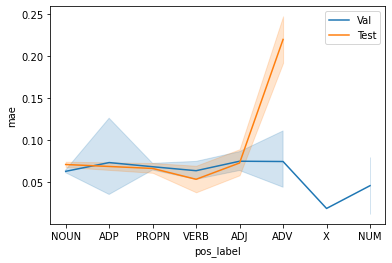

Window size of: 1


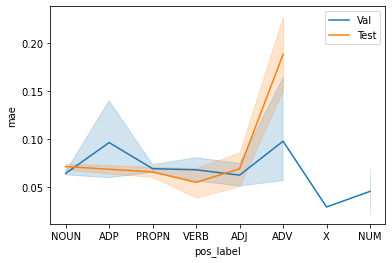

Window size of: 2


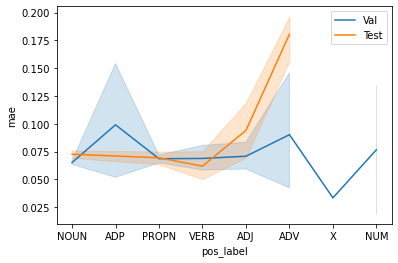

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for window_ix in results_window:
    print('Window size of:', window_ix)
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'val')], 
                    ci=98, 
                    markers='o')
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'test')], 
                    ci=98, 
                    markers='o')
    plt.legend(['Val', 'Test'])
    plt.show()

# Predict

In [15]:
epochs = 20
seed_val = 2
results_window = {}
max_len = 22
stop_at = 5
cuda_card = 1
nlp = spacy.load("en_core_web_sm")

In [16]:
data_sent_dis, data_senses_dis = read_disambiguation_corpus(max_len=max_len)

In [9]:
tag_values = list(set(list(itertools.chain(*data_senses_dis))))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [10]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0, 1, 2]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions, _, pos_tags = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                            nlp,
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    trial_texts, _, trial_labels, sentences_trial, trial_target_words, trial_positions, _, trial_pos_tags= read_lexical_corpus('data/raw/lcp_single_trial.xlsx',
                                                                            nlp,
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    le = LabelEncoder()
    le.fit(pos_tags)
    pos_tags_f = le.transform(pos_tags)
    trial_pos_tags_f = le.transform(trial_pos_tags)

    pos_tags_f = np.reshape(pos_tags_f, (-1, 1))
    trial_pos_tags_f = np.reshape(trial_pos_tags_f, (-1, 1))
    
    torch.cuda.manual_seed_all(seed_val)

    history_preds_val = []
    history_preds_test = []
    history_samples_val = []
    history_samples_test = []
    history_input = []
    history_input_test = []
    history_target = []
    history_target_test = []
    history_index = []
    history_index_test = []
    history_labels_val = []
    history_labels_test = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    train_index = list(range(len(data_texts)))
    random.seed(seed_val)
    random.shuffle(train_index)
    train_index = np.array(train_index)

    train_texts_lex, train_labels_lex, train_positions_lex, train_target_words_lex, train_pos_tags = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index], pos_tags_f[train_index]
    #train_texts_lex, train_labels_lex, train_positions_lex, train_target_words_lex, train_pos_tags = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index], pos_tags_f[train_index]
    #val_texts_lex, val_labels_lex, val_positions_lex, val_target_words_lex, val_pos_tags = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index], pos_tags_f[val_index]

    train_encodings_lex = tokenizer(list(train_texts_lex), truncation=True, padding=True)

    val_encodings_lex = tokenizer(list(trial_texts), truncation=True, padding=True)
    val_dataset_lex = ComposeDataset(val_encodings_lex, trial_labels, trial_positions, trial_pos_tags_f)
    val_loader_lex = DataLoader(val_dataset_lex, batch_size=1)
        
    all_text = ' '.join(data_texts)
    occurence_text = [all_text.count(w) for w in trial_target_words]
                
    device = torch.device(f"cuda:{cuda_card}")
    #device = torch.device(f"cpu")
        
    model = BertTaggingForSharedTaskMultitask.from_pretrained(
        "bert-base-uncased", 
        num_labels = len(tag2idx), 
        output_attentions = False, 
        output_hidden_states = False, 
    )
    model.cuda(cuda_card)

    optimizer = AdamW(model.parameters(),
                      lr = 2e-5, 
                      eps = 1e-8
                      )

    random.seed(seed_val)
    torch.manual_seed(seed_val)

    tracking_metrics_val = []
    tracking_logits_val = []

    #tracking_metrics_test = []
    #tracking_logits_test = []
        
    early_stopping = 0
    best_metric = 1000000
        
    for epoch_i in range(0, epochs):
        np.random.seed(epoch_i)
        sample_data_sent = np.random.choice(data_sent_dis, len(train_texts_lex), replace=False)
            
        np.random.seed(epoch_i)
        sample_data_sense = np.random.choice(data_senses_dis, len(train_texts_lex), replace=False)
            
        train_encodings_dis = tokenizer(list(sample_data_sent), truncation=True, padding=True, max_length=max_len)
        data_tags_dis = pad_sequences([[tag2idx.get(l) for l in lab] for lab in sample_data_sense],
                    maxlen=max_len, value=tag2idx["PAD"], padding="post",
                    dtype="long", truncating="post")
            
        train_dataset_multi = ComposeMultiDataset(train_encodings_dis, data_tags_dis, train_encodings_lex, train_labels_lex, train_positions_lex, train_pos_tags)
        train_loader_multi = DataLoader(train_dataset_multi, batch_size=16)
            
        total_steps = len(train_loader_multi) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)           
        print()
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        train(device, model, train_loader_multi, forward_func_multitask_same_bert, optimizer, scheduler, {})
            
        _, val_logits, val_metric = evaluate(device, model, val_loader_lex, forward_func_multitask_bert, {'task_id': 1})
        #_, test_logits, test_metric = evaluate(device, model, test_loader, forward_func_multitask_bert, {'task_id': 1})

        tracking_metrics_val.append(val_metric)
        tracking_logits_val.append(val_logits)

        #tracking_metrics_test.append(test_metric)
        #tracking_logits_test.append(test_logits)
            
        if val_metric > best_metric:
            early_stopping += 1
        else:
            best_metric = val_metric
            early_stopping = 0
                
        if early_stopping == stop_at:
            break
            
    index_min = np.argmin(tracking_metrics_val)
            
    history_labels_val.extend(trial_labels)
    #history_labels_test.extend(test_labels)
    history_preds_val.extend(tracking_logits_val[index_min])
    #history_preds_test.extend(tracking_logits_test[index_min])
    history_samples_val.extend(trial_texts)
    #history_samples_test.extend(test_texts)
    history_input.extend(sentences_trial)
    #history_input_test.extend(sentences_test)
    history_target.extend(trial_target_words)
    #history_target_test.extend(test_target_words)
    #history_index.extend(([ix_fold] * len(val_index)))
    #history_index_test.extend(([ix_fold] * len(test_texts)))
    history_occur_text.extend(occurence_text)
    #history_occur_target.extend(occurence_target)
    ix_fold += 1

    print("")
    print("Training complete!")
    print(f"Best metric: {tracking_metrics_val[index_min]}")
        
    del model
    torch.cuda.empty_cache()
        
    results_val = pd.DataFrame()
    results_val['samples'] = history_samples_val
    results_val['preds'] = history_preds_val
    results_val['true'] = history_labels_val
    results_val['raw'] = history_input
    results_val['raw'] = results_val['raw'].astype(str)
    results_val['target'] = history_target
    results_val['occur_text'] = history_occur_text
    #results_val['occur_target'] = history_occur_target
    results_val['particion'] = 'val'

    #results_test = pd.DataFrame()
    #results_test['samples'] = history_samples_test
    #results_test['preds'] = history_preds_test
    #results_test['true'] = history_labels_test
    #results_test['raw'] = history_input_test
    #results_test['raw'] = results_test['raw'].astype(str)
    #results_test['index'] = history_index_test
    #results_test['target'] = history_target_test
    #results_test['particion'] = 'test'

    #results = pd.concat((results_val, results_test), axis=0)

    results_window[window_x] = results_val

Window size of  0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertTaggingForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertTaggingForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertTaggingForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertTaggingForSharedTaskMultitask were not initialized from the mod


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.245316

Running Validation...
  Metric: 0.073369
  Validation Loss: 0.008893


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 2 / 20 ========
Training...


In [28]:
submit = pd.read_excel('data/raw/lcp_single_trial.xlsx')

In [29]:
submit['']

,id,subcorpus,sentence,token,complexity
0,3QI9WAYOGQB8GQIR4MDIEF0D2RLS67,bible,They will not hurt nor destroy in all my holy ...,sea,0.000000
1,3T8DUCXY0N6WD9X4RTLK8UN1U929TF,bible,"that sends ambassadors by the sea, even in ves...",sea,0.102941
2,3I7KR83SNADXAQ7HXK7S7305BYB9KD,bible,"and they entered into the boat, and were going...",sea,0.109375
3,3BO3NEOQM0HK9ERYPN0GQIWCPC4IAQ,bible,"Joseph laid up grain as the sand of the sea, v...",sea,0.160714
4,3Y3CZJSZ9KT0W7I0KE38WZHHKSW5RH,bible,There will be a highway for the remnant that i...,land,0.000000


In [22]:
results_window[0]

,samples,preds,true,raw,target,occur_text,particion
0,sea,0.162925,0.000000,They will not hurt nor destroy in all my holy ...,sea,30,val
1,sea,0.162925,0.102941,"that sends ambassadors by the sea , even in ve...",sea,30,val
2,sea,0.162925,0.109375,"and they entered into the boat , and were goin...",sea,30,val
3,sea,0.162925,0.160714,"Joseph laid up grain as the sand of the sea , ...",sea,30,val
4,land,0.195363,0.000000,There will be a highway for the remnant that i...,land,15,val
...,...,...,...,...,...,...,...
306,EC,0.546639,0.482143,"the report by Mrs Jöns , on behalf of the Comm...",EC,3,val
307,EC,0.546639,0.500000,The proposal to amend Regulation ( EC ) No 539...,EC,3,val
308,EC,0.546639,0.605263,"the report by Mr Albertini , on behalf of the ...",EC,3,val
309,peat,0.342868,0.482143,The Rospuda valley is the last peat bog system...,peat,0,val


In [23]:
results_window[1]

,samples,preds,true,raw,target,occur_text,particion
0,the sea .,0.197609,0.000000,They will not hurt nor destroy in all my holy ...,sea,39,val
1,"the sea ,",0.185351,0.102941,"that sends ambassadors by the sea , even in ve...",sea,39,val
2,the sea to,0.182555,0.109375,"and they entered into the boat , and were goin...",sea,39,val
3,"the sea ,",0.185351,0.160714,"Joseph laid up grain as the sand of the sea , ...",sea,39,val
4,the land of,0.183619,0.000000,There will be a highway for the remnant that i...,land,25,val
...,...,...,...,...,...,...,...
306,( EC ),0.582400,0.482143,"the report by Mrs Jöns , on behalf of the Comm...",EC,8,val
307,( EC ),0.582400,0.500000,The proposal to amend Regulation ( EC ) No 539...,EC,8,val
308,( EC ),0.582400,0.605263,"the report by Mr Albertini , on behalf of the ...",EC,8,val
309,last peat bog,0.333735,0.482143,The Rospuda valley is the last peat bog system...,peat,4,val


In [26]:
results_window[2]

,samples,preds,true,raw,target,occur_text,particion
0,cover the sea .,0.174167,0.000000,They will not hurt nor destroy in all my holy ...,sea,53,val
1,"by the sea , even",0.173243,0.102941,"that sends ambassadors by the sea , even in ve...",sea,53,val
2,over the sea to Capernaum,0.186244,0.109375,"and they entered into the boat , and were goin...",sea,53,val
3,"of the sea , very",0.187044,0.160714,"Joseph laid up grain as the sand of the sea , ...",sea,53,val
4,of the land of Egypt,0.215643,0.000000,There will be a highway for the remnant that i...,land,37,val
...,...,...,...,...,...,...,...
306,Regulation ( EC ) No,0.608495,0.482143,"the report by Mrs Jöns , on behalf of the Comm...",EC,12,val
307,Regulation ( EC ) No,0.608495,0.500000,The proposal to amend Regulation ( EC ) No 539...,EC,12,val
308,Regulation ( EC ) No,0.608495,0.605263,"the report by Mr Albertini , on behalf of the ...",EC,12,val
309,the last peat bog system,0.297181,0.482143,The Rospuda valley is the last peat bog system...,peat,5,val


In [24]:
results_window[1].iloc[0].raw

'They will not hurt nor destroy in all my holy mountain ; for the earth will be full of the knowledge of Yahweh , as the waters cover the sea .'

In [25]:
results_window[1].iloc[1].raw

'that sends ambassadors by the sea , even in vessels of papyrus on the waters , saying , " Go , you swift messengers , to a nation tall and smooth , to a people awesome from their beginning onward , a nation that measures out and treads down , whose land the rivers divide ! "'